# Rectify
Does using "normalized" mean state improve RO's ability to simulate mean state? Based on this reference:  
Huang, P., Chen, Y., Li, J. & Yan, H. "Redefined background state in the tropical Pacific resolves the entanglement between the background state and ENSO". *npj Clim Atmos Sci* 7, 147 (2024).

## Imports

In [1]:
import warnings
import datetime
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import numpy as np
import seaborn as sns
import xarray as xr
import tqdm
import pathlib
import cmocean
import pandas as pd
import os
import scipy.stats

# Import custom modules
from src.XRO import XRO, xcorr
import src.utils

## set plotting specs
sns.set(rc={"axes.facecolor": "white", "axes.grid": False})

## bump up DPI
mpl.rcParams["figure.dpi"] = 100

## get filepaths
DATA_FP = pathlib.Path(os.environ["DATA_FP"])
SAVE_FP = pathlib.Path(os.environ["SAVE_FP"])

## Functions

In [2]:
def plot_pdf(ax, x, edges, **plot_kwargs):
    """Plot empirical PDF on given ax for specified data (x),
    using specified edges for histogram"""

    ## compute pdf, skewness, and gaussian best fit
    pdf, _ = src.utils.get_empirical_pdf(x, edges=edges)
    skew = scipy.stats.skew(x)
    pdf_gauss, pdf_gauss_pts = src.utils.get_gaussian_best_fit(x)

    ## plot pdf
    ax.stairs(pdf, edges, lw=1.5, label=f"skew = {skew:.2f}", **plot_kwargs)

    ## plot gaussian best fit
    ax.plot(pdf_gauss_pts, pdf_gauss, c="k", lw=1)

    ## label and hide yticks
    ax.legend(prop=dict(size=8))
    ax.set_yticks([])

    return ax

## Load data

In [3]:
## ORAS5 reanalysis (use as benchmark)
oras_load_fp = pathlib.Path(DATA_FP, "XRO_indices_oras5.nc")
Th_oras = xr.open_dataset(oras_load_fp)

## rename variables for consistency and trim so time periods covered are the same
Th_oras = Th_oras[["Nino34", "WWV"]].rename({"Nino34": "T", "WWV": "h"})

## PDFs

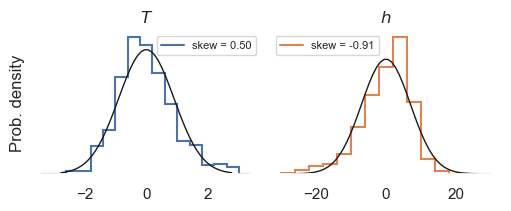

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(5, 2), layout="constrained")

## plot data
colors = sns.color_palette()[:2]
ax0 = plot_pdf(
    axs[0], Th_oras["T"].values, edges=np.arange(-3.4, 3.8, 0.4), color=colors[0]
)
ax1 = plot_pdf(
    axs[1], Th_oras["h"].values, edges=np.arange(-30, 32, 4), color=colors[1]
)

## label
ax0.set_title(r"$T$")
ax1.set_title(r"$h$")
ax0.set_ylabel("Prob. density")
plt.show()